In [1]:
# Set up libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
from configparser import ConfigParser
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 


Bad key "text.kerning_factor" on line 4 in
C:\Users\HOME\Anaconda3\envs\SEGP\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Configure the connection
config = ConfigParser()
config.read("config.ini")
options = config["DataBase"]

engine = create_engine("mysql://" + options["user"] + ":" + options["passwd"] + "@" + options["host"] + "/" + options["database"])
engine.connect()

In [3]:
## Rough work for weekly predictions
# Set up the SQL command and turn into dataframe
stat_2 = "SELECT * FROM dublinbikes.dynamic_data WHERE number = 2"
sql_df = pd.read_sql(stat_2,engine)
print(sql_df.shape)
sql_df.head(5)

(9241, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,2,1581417540,20,20,0,OPEN
1,2,1581418200,20,20,0,OPEN
2,2,1581418800,20,20,0,OPEN
3,2,1581419400,20,20,0,OPEN
4,2,1581420000,20,20,0,OPEN


In [4]:
# check for duplicates
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  0
Number of duplicate columns:  0


In [5]:
# looking at 'last_update'
count, count2 = 0,0
for line in sql_df['last_update']:
    if len(str(line)) > 10:
        count += 1
    else:
        count2 += 1
        
print("Last update in len 10 format: ", count2)
print("Last update in len 13 format: ", count)

Last update in len 10 format:  3981
Last update in len 13 format:  5260


In [6]:
# converting 'last_update' enties from 13 digits to the required 10
for i in range(sql_df.shape[0]):
    convert = str(sql_df['last_update'][i])
    if len(convert) > 10:
        sql_df.at[i,'last_update'] = int(convert[:10])


In [7]:
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  1
Number of duplicate columns:  0


In [8]:
sql_df[sql_df.duplicated(keep=False)]

,number,last_update,bike_stands,available_bike_stands,available_bikes,status
3980,2,1583234161,20,20,0,OPEN
3981,2,1583234161,20,20,0,OPEN


In [9]:
sql_df = sql_df.drop_duplicates()
sql_df = sql_df.reset_index(drop=True)
print(sql_df.shape)
sql_df.head(5)


(9240, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,2,1581417540,20,20,0,OPEN
1,2,1581418200,20,20,0,OPEN
2,2,1581418800,20,20,0,OPEN
3,2,1581419400,20,20,0,OPEN
4,2,1581420000,20,20,0,OPEN


In [10]:
# moving target feature to end
sql_df = sql_df[['number', 'last_update', 'bike_stands', 'available_bike_stands', 'status', 'available_bikes']]
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,2,1581417540,20,20,OPEN,0
1,2,1581418200,20,20,OPEN,0
2,2,1581418800,20,20,OPEN,0
3,2,1581419400,20,20,OPEN,0
4,2,1581420000,20,20,OPEN,0


In [11]:
# convert update to datetime
sql_df['last_update'] = sql_df['last_update'].apply(lambda x: datetime.fromtimestamp(x))
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,20,20,OPEN,0
1,2,2020-02-11 10:50:00,20,20,OPEN,0
2,2,2020-02-11 11:00:00,20,20,OPEN,0
3,2,2020-02-11 11:10:00,20,20,OPEN,0
4,2,2020-02-11 11:20:00,20,20,OPEN,0


In [12]:
# adding day of the week column
sql_df.insert(2, 'day_of_week', 0)
sql_df['day_of_week'] = sql_df['last_update'].apply(lambda x: x.dayofweek )
sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,1,20,20,OPEN,0
1,2,2020-02-11 10:50:00,1,20,20,OPEN,0
2,2,2020-02-11 11:00:00,1,20,20,OPEN,0
3,2,2020-02-11 11:10:00,1,20,20,OPEN,0
4,2,2020-02-11 11:20:00,1,20,20,OPEN,0
...,...,...,...,...,...,...,...
9235,2,2020-04-02 12:08:25,3,20,15,OPEN,5
9236,2,2020-04-02 12:13:21,3,20,14,OPEN,6
9237,2,2020-04-02 12:23:30,3,20,14,OPEN,6
9238,2,2020-04-02 12:33:39,3,20,14,OPEN,6


In [13]:
# remove lines of repeated data
r_day, r_stand, r_bike = 0,0,0
clean_sql_df = pd.DataFrame()
for i in range(sql_df.shape[0]):
    c_day = sql_df['day_of_week'][i]
    c_stand = sql_df['available_bike_stands'][i]
    c_bike = sql_df['available_bikes'][i]
    if r_day == c_day and r_stand == c_stand and r_bike == c_bike:
        continue
    else:
        r_day, r_stand, r_bike = c_day, c_stand, c_bike
        clean_sql_df = clean_sql_df.append([sql_df.iloc[i]])


clean_sql_df = clean_sql_df.reset_index(drop=True)
clean_sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,1,20,20,OPEN,0
1,2,2020-02-11 11:26:00,1,20,19,OPEN,1
2,2,2020-02-11 11:39:00,1,20,20,OPEN,0
3,2,2020-02-11 15:38:00,1,20,19,OPEN,1
4,2,2020-02-11 15:43:00,1,20,18,OPEN,2
...,...,...,...,...,...,...,...
2557,2,2020-04-02 08:24:10,3,20,12,OPEN,8
2558,2,2020-04-02 10:54:51,3,20,13,OPEN,7
2559,2,2020-04-02 11:39:46,3,20,14,OPEN,6
2560,2,2020-04-02 11:58:17,3,20,15,OPEN,5


In [14]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [15]:
# Preparing Data
cont_features = ['day_of_week']
X = clean_sql_df[cont_features]
y = clean_sql_df.available_bikes

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train)
# train the model
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)

In [16]:
train_predictions = linreg.predict(X_train)
print("Actual values of training:\n", y_train)
print("Predictions on training:", train_predictions)
printMetrics(y_train, train_predictions)

Actual values of training:
 1330     4
1691     2
900     16
792      2
31      12
        ..
1033     5
1731    12
763      1
835      5
1653     0
Name: available_bikes, Length: 1793, dtype: int64
Predictions on training: [6.09264512 6.70338795 6.70338795 ... 7.92487361 7.31413078 7.31413078]

MAE:  4.323638841482435
RMSE:  5.129907211708863
R2:  0.04328932036583655


In [17]:
test_predictions = linreg.predict(X_test)
print("Actual values of training:\n", y_test)
print("Predictions on training:", test_predictions)
printMetrics(y_test, test_predictions)

Actual values of training:
 918     18
1668     4
727      2
1137     0
1271     4
        ..
250      1
169      1
1328     6
1359     1
1989    13
Name: available_bikes, Length: 769, dtype: int64
Predictions on training: [6.70338795 6.70338795 4.26041662 7.92487361 6.70338795 4.87115945
 6.70338795 5.48190228 5.48190228 6.70338795 5.48190228 5.48190228
 6.09264512 6.70338795 6.09264512 6.70338795 5.48190228 6.70338795
 7.31413078 6.09264512 7.31413078 5.48190228 7.31413078 7.92487361
 7.31413078 5.48190228 6.09264512 7.31413078 7.31413078 7.31413078
 4.87115945 6.70338795 4.87115945 6.09264512 5.48190228 4.87115945
 5.48190228 5.48190228 4.26041662 5.48190228 7.31413078 6.70338795
 6.70338795 6.09264512 6.70338795 6.70338795 5.48190228 7.31413078
 6.09264512 4.87115945 4.26041662 7.31413078 4.26041662 6.70338795
 4.87115945 6.09264512 7.92487361 4.26041662 4.87115945 7.31413078
 7.31413078 4.87115945 4.26041662 6.09264512 7.92487361 6.09264512
 6.70338795 7.92487361 7.31413078 7.9248

In [18]:
# predict whole table
predicted_bikes = linreg.predict(X)
pb_df = clean_sql_df.assign(predicted_bikes=predicted_bikes)

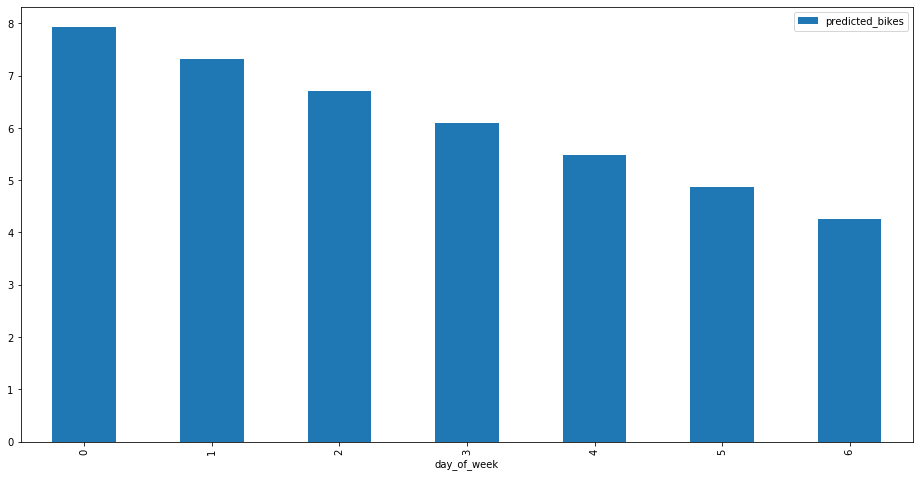

In [19]:
plot_data = pb_df[['day_of_week','predicted_bikes']]
plot_data = plot_data.groupby('day_of_week').mean()
# plot_out = plot_data.plot(x=plot_data[0], y='predicted_bikes',kind='bar', figsize=(16,8))
# plot_data = plot_data.groupby(['day_of_week','predicted_bikes']).count().unstack('predicted_bikes').fillna(0)
plot_out = plot_data.plot(kind='bar', stacked=True, figsize=(16,8))


In [20]:
clean_sql_df
usage_data = pd.DataFrame(columns=['day_of_week', 'usage'])
r_day,r_count = 0,0

for i in range(clean_sql_df.shape[0]):
    c_day = clean_sql_df['day_of_week'][i]
    date = clean_sql_df['last_update'][i]
    if date.month == 3 and date.day > 15:
        usage_data.loc[i] = [r_day] + [r_count]
        break
    if r_day != c_day and r_count == 0:
        r_day = c_day
        r_count += 1
    elif r_day != c_day and r_count > 0:
        usage_data.loc[i] = [r_day] + [r_count]
        r_day = c_day
        r_count = 1
    elif r_day == c_day:
        r_count += 1
    else:
        print("Something Odd in the Data {} {} {}".format(r_day,r_count,c_day))
usage_data = usage_data.reset_index(drop=True)
usage_data

,day_of_week,usage
0,1,35
1,2,50
2,3,65
3,4,65
4,5,55
5,6,35
6,0,34
7,1,29
8,2,99
9,3,76


In [21]:
# Preparing Data
cont_features = ['day_of_week']
X = usage_data[cont_features]
y = usage_data.usage

# split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train)
# train the model
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X, y)

In [22]:
# train_predictions = linreg.predict(X_train)
# print("Actual values of training:\n", y_train)
# print("Predictions on training:", train_predictions)
# printMetrics(y_train, train_predictions)

[59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578]
   day_of_week usage  predicted_usage
0            1    35        59.366254
1            2    50        58.204949
2            3    65        57.043645
3            4    65        55.882340
4            5    55        54.721035
5            6    35        53.559730
6            0    34        60.527559
7            1    29        59.366254
8 

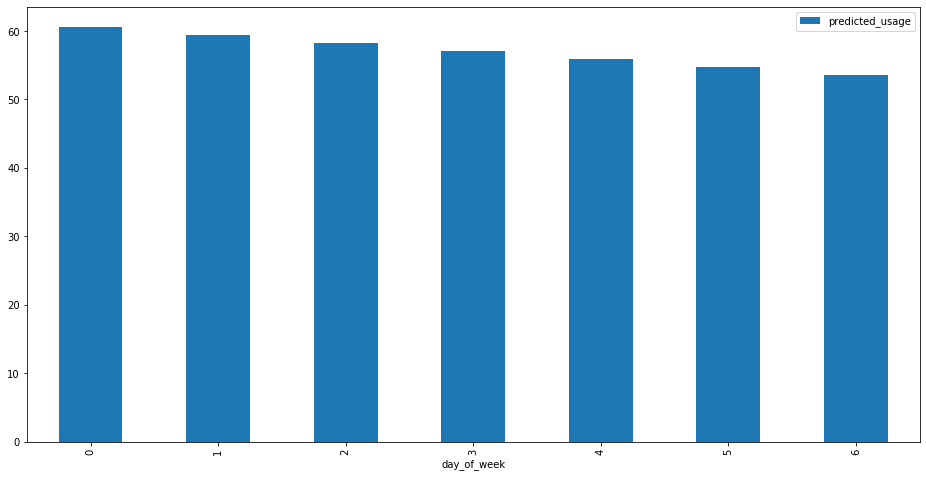

In [23]:
# predict whole table
predicted_usage = linreg.predict(X)
print(list(predicted_usage))
pu_df = usage_data.assign(predicted_usage=predicted_usage)
print(pu_df)
plot_data = pu_df[['day_of_week','predicted_usage']]
plot_data = plot_data.groupby('day_of_week').mean()
# plot_out = plot_data.plot(x=plot_data[0], y='predicted_bikes',kind='bar', figsize=(16,8))
# plot_data = plot_data.groupby(['day_of_week','predicted_bikes']).count().unstack('predicted_bikes').fillna(0)
plot_out = plot_data.plot(kind='bar', stacked=True, figsize=(16,8))


In [24]:
temp_data = pu_df[['day_of_week','usage']]
# temp_data.to_csv ('export_dataframe.csv', index = False, header=True)

In [25]:
df_0 = pd.DataFrame()
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_3 = pd.DataFrame()
df_4 = pd.DataFrame()
df_5 = pd.DataFrame()
df_6 = pd.DataFrame()

for i in range(usage_data.shape[0]):
    if usage_data['day_of_week'][i] == 0:
        df_0 = df_0.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 1:
        df_1 = df_1.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 2:
        df_2 = df_2.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 3:
        df_3 = df_3.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 4:
        df_4 = df_4.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 5:
        df_5 = df_5.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 6:
        df_6 = df_6.append([usage_data.iloc[i]])
        


[41.75]
Empty DataFrame
Columns: [day_of_week, predict]
Index: []
73.6
             predict
day_of_week         
0.0            41.75
1.0            53.40
2.0            73.60
3.0            68.20
4.0            69.00
5.0            53.40
6.0            36.20


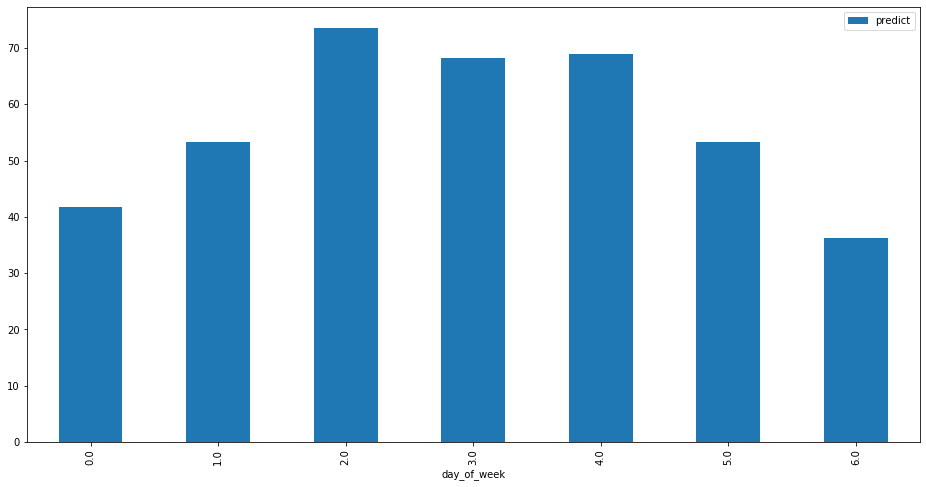

In [26]:
# playing around dont mind this
X0 = df_0[cont_features]
y0 = df_0.usage
linreg0 = LinearRegression().fit(X0, y0)

X1 = df_1[cont_features]
y1 = df_1.usage
linreg1 = LinearRegression().fit(X1, y1)

X2 = df_2[cont_features]
y2 = df_2.usage
linreg2 = LinearRegression().fit(X2, y2)

X3 = df_3[cont_features]
y3 = df_3.usage
linreg3 = LinearRegression().fit(X3, y3)

X4 = df_4[cont_features]
y4 = df_4.usage
linreg4 = LinearRegression().fit(X4, y4)

X5 = df_5[cont_features]
y5 = df_5.usage
linreg5 = LinearRegression().fit(X5, y5)

X6 = df_6[cont_features]
y6 = df_6.usage
linreg6 = LinearRegression().fit(X6, y6)

xdata = [0, 1, 2, 3, 4, 5, 6]
print(linreg0.predict(X0.head(1)))
ydata = [linreg0.predict(X0.head(1)),linreg1.predict(X1.head(1)),linreg2.predict(X2.head(1)),linreg3.predict(X3.head(1)),linreg4.predict(X4.head(1)),linreg5.predict(X5.head(1)),linreg6.predict(X6.head(1))]
plotdata2 = pd.DataFrame(columns = ['day_of_week', 'predict'])
print(plotdata2)
for i in xdata:
    plotdata2.loc[i] = [xdata[i]]+[ydata[i][0]]
print(plotdata2.predict[2])
plotdata2 = plotdata2.groupby('day_of_week').mean()
plot_out = plotdata2.plot(kind='bar', stacked=True, figsize=(16,8))
print(plotdata2)
# sql = "INSERT INTO dublinbikes.station_week_prediction (number, mon, tue, wed, thur, fri, sat, sun) VALUES ({}, {}, {}, {}, {}, {}, {}, {});".format(2,plotdata2.predict[0],plotdata2.predict[1],plotdata2.predict[2],plotdata2.predict[3],plotdata2.predict[4],plotdata2.predict[5],plotdata2.predict[6])
# sql2 = "UPDATE dublinbikes.station_week_prediction SET mon = 1, tue = 1, wed = 1, thur = 1, fri = 1, sat = 1, sun = 1 WHERE (number = 2);"
# print(sql)
# try:
#     engine.execute(sql)
# except:
#     engine.execute(sql2)



In [27]:
# def weekModelBuilding():
station = "SELECT number FROM dublinbikes.static_data"
stat_df = pd.read_sql(station,engine)
print(stat_df.shape)
stat_df.head(5)

(109, 1)


,number
0,2
1,3
2,4
3,5
4,6


In [28]:
station = 2
bikes_data = """SELECT bd.number, bd.last_update, bd.available_bikes, wa.weather_station
                FROM dublinbikes.bike_weather_assoc wa, dublinbikes.dynamic_data bd
                WHERE bd.number=wa.bike_station_id and bd.number = {};""".format(station)
bikes_df = pd.read_sql(bikes_data, engine)

weather_data = "SELECT name, weather_id, main_temp, main_humidity, wind_speed, dt FROM dublinbikes.weather_dynamic WHERE name = '{}';".format(bikes_df.weather_station[0])

weather_df = pd.read_sql(weather_data, engine)

In [29]:
bikes_df.head(5)

,number,last_update,available_bikes,weather_station
0,2,1581417540,0,Drumcondra
1,2,1581418200,0,Drumcondra
2,2,1581418800,0,Drumcondra
3,2,1581419400,0,Drumcondra
4,2,1581420000,0,Drumcondra


In [30]:
weather_df.head(5)

,name,weather_id,main_temp,main_humidity,wind_speed,dt
0,Drumcondra,803,276.66,80.0,4.1,1582749064
1,Drumcondra,802,279.98,62.0,8.7,1582814540
2,Drumcondra,803,276.57,69.0,3.1,1582836811
3,Drumcondra,803,276.62,69.0,3.1,1582837802
4,Drumcondra,803,277.13,69.0,2.6,1582839002
